## Between 2008 and 2018, did childhood obesity prevalence change at different rates in London’s local authorities than in local authorities outside London? 

#### 1. Importing libraries and reading in data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import scipy.stats as sps
from matplotlib.ticker import AutoMinorLocator
from statsmodels.distributions.empirical_distribution import ECDF

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot')

df = pd.read_csv('coursework_1_data_2019.csv')
#Set index for data frame to 'local_authority_area' column
df.set_index('local_authority_area', inplace=True)

#### 2. Calculating percent change in childhood obesity prevalence for each local authority between 2008 and 2018

##### a) Calculating childhood obesity prevalence in 2008 and 2018 for each local authority

In [2]:
#Formula for calculating childhood obesity prevalence, measured as childhood obesity cases per 100,000 residents
def case_rate_100000(cases, pop):
    return (cases/pop)*100000

#Initialise dictionary with inputs needed for childhood obesity prevalence function
#keys will be names of new columns, values will be existing columns used to calculate new column
case_rates = {}
#Dynamically generate dictionary
col_list = [0,2]
for col in df.columns[col_list]:
    col_split = col.split('_') #returns list of strings in column, using underscore as separator
    case_rates[f'{col_split[0]}_rate'] = [col for col in df.columns if (col.startswith(col_split[0])) and (col.endswith('_' + col_split[2]))]
    #generates dict key that starts with correct year and
    #sets value equal to column names in data frame that correspond to total cases + population for the same year [col_split[0]] and group [col_split[2]]
    #(I really could have just copied column names, but I initially calculated prevalence for males and females per year as well, which required more copy and pasting than I was willing to do)
    
#Use dictionary to dynamically generate new columns for data frame
for k,v in case_rates.items():
    df[k] = case_rate_100000(df[v[0]], df[v[1]])  

##### b) Calculating percentage change in childhood obesity prevalence between 2008 and 2018

In [3]:
def rate_change(x1, x2):
    return ((x2 - x1)/x1)*100

df['total_rate_change'] = rate_change(df['2008_rate'], df['2018_rate'])

#### 3. Creating a new variable encoding whether or not a local authority is in London

In [4]:
df['is_london'] = np.where(df['region'] == 'London', 1, 0) 
    #first argument is condition, second is value for if true, third is value for if false

#### 4. Creating summary statistics tables for childhood obesity prevalence changes

##### a) Combined summary (London and non-London)

In [5]:
df[['total_rate_change']].describe()

,total_rate_change
count,152.0000
mean,13.6571
std,12.2323
min,-27.8689
25%,5.9056
50%,9.9542
75%,20.3996
max,66.2787


##### b) Summary for London and non-London local authorities

In [6]:
df.groupby(['is_london'])[['total_rate_change']].describe() #0 is not London, 1 is London

total_rate_change  \
                                             count   
is_london                                            
0                                         119.0000   
1                                          33.0000   

                                                    \
                                              mean   
is_london                                            
0                                           9.4707   
1                                          28.7537   

                                                    \
                                               std   
is_london                                            
0                                           8.5116   
1                                          11.7775   

                                                    \
                                               min   
is_london                                            
0                                         -27.8689   
1                                           5.2609   

                                                    \
                                               25%   
is_london                                            
0                                           4.7495   
1                                          22.3259   

                                                    \
                                               50%   
is_london                                            
0                                           8.4787   
1                                          27.5032   

                                                    \
                                               75%   
is_london                                            
0                                          13.5160   
1                                          34.5516   

                                                    
                                               max  
is_london                                           
0                                          37.0037  
1                                          66.2787

#### 5. Determining whether childhood obesity prevalence changes are normally distributed in London and non-London local authorities

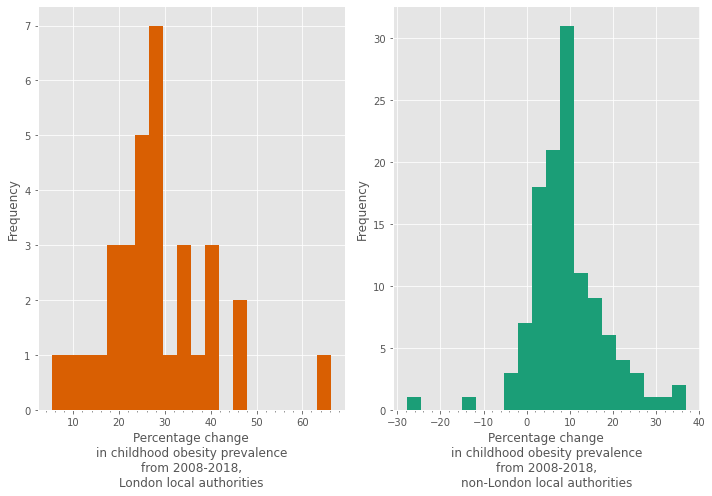

In [7]:
x1 = df[df['is_london'] == 1]['total_rate_change']
x2 = df[df['is_london'] == 0]['total_rate_change']

fig1 = plt.figure(figsize=(10,7))
ax1 = plt.subplot(1, 2, 1)
ax1 = x1.plot.hist(bins=20, color='#d95f02')
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.set(xlabel='Percentage change\nin childhood obesity prevalence\nfrom 2008-2018,\nLondon local authorities')

ax2 = plt.subplot(1, 2, 2)
ax2 = x2.plot.hist(bins=20, color='#1b9e77')
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.set(xlabel='Percentage change\nin childhood obesity prevalence\nfrom 2008-2018,\nnon-London local authorities')

plt.tight_layout()
plt.savefig('fig1_hist.png')

The Shapiro-Wilk test returns a data set's similarity to the normal distribution curve, with the null hypothesis being that the data set is normally distributed. A p-value of less than 0.05 indicates that the data set is not normally distributed. 

In [8]:
stat_ldn, p_ldn = sps.shapiro(x1)
print(f"London: {stat_ldn, p_ldn}")
stat_nldn, p_nldn = sps.shapiro(x2)
print(f"Non-London: {stat_nldn, p_nldn}")

London: (0.9499711990356445, 0.13277944922447205)
Non-London: (0.9252148866653442, 5.318538569554221e-06)


#### 6. Conducting the Kolmogorov-Smirnov two-sample test to compare distributions of childhood obesity prevalence changes

##### a) Plotting each sample's empirical cumulative distribution function (ECDF)

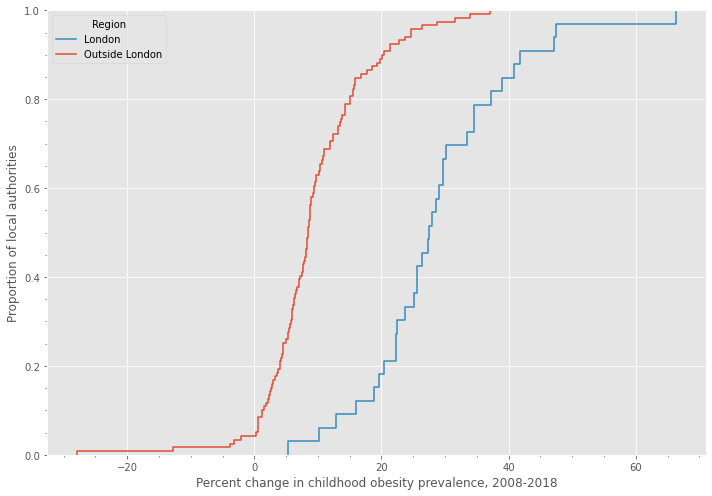

In [9]:
cdf = plt.figure(figsize=(10,7))
cdf = sn.ecdfplot(df, x='total_rate_change', hue='is_london', legend=False)
cdf.set(xlabel='Percent change in childhood obesity prevalence, 2008-2018', 
        ylabel='Proportion of local authorities')
cdf.xaxis.set_minor_locator(AutoMinorLocator())
cdf.yaxis.set_minor_locator(AutoMinorLocator())
plt.legend(title='Region', loc='upper left', labels=['London', 'Outside London'])

plt.tight_layout()
plt.savefig('fig2_ecdf.png')

The shared range for the two groups falls between the minimum childhood obesity prevalence change in London and the maximum childhood obesity prevalence change outside of London. 

In [20]:
#What percentage of London local authorities have childhood obesity prevalence changes within the shared range?
df[
    (df['is_london'] == 1) &
    (df['total_rate_change'] < x2.max())
]['is_london'].count() / 33 * 100

78.78787878787878

In [23]:
#What percentage of non-London local authorities have childhood obesity prevalence changes within the shared range?
df[
    (df['is_london'] == 0) &
    (df['total_rate_change'] > x1.min())
]['is_london'].count() / 119 * 100

73.10924369747899

##### b) The KS test

In [61]:
KSstat, pval = sps.ks_2samp(x1, x2)
print(KSstat)
print(pval)

0.7578304048892284
2.7755575615628914e-15
